![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Author**: EUMETSAT <br>
**Copyright**: 2024 EUMETSAT <br>
**Licence**: MIT <br>

## Destination Earth - Weather-Induced Extremes Digital Twin - Data Access using DEDL HDA

[Documentation DestinE Data Lake HDA](https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/dedl-discovery-and-data-access.html)

[Documentation Digital Twin - Parameter Usage](https://confluence.ecmwf.int/display/DDCZ/DestinE+Parameter+Portfolios)

<br> Author: EUMETSAT </br>

Credit: Earthkit and HDA Polytope used in this context are both packages provided by the European Centre for Medium-Range Weather Forecasts (**ECMWF**).

DEDL Harmonised Data Access is used in this example.</br>

## Obtain Authentication Token

In [1]:
import requests
import json
import os
from getpass import getpass
import destinelab as deauth

### Query using the DEDL HDA API


First, we get an access token for the API

In [2]:
DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

auth = deauth.AuthHandler(DESP_USERNAME, DESP_PASSWORD)
access_token = auth.get_token()
if access_token is not None:
    print("DEDL/DESP Access Token Obtained Successfully")
else:
    print("Failed to Obtain DEDL/DESP Access Token")

auth_headers = {"Authorization": f"Bearer {access_token}"}

Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


Response code: 200
DEDL/DESP Access Token Obtained Successfully


## Filter
We have to setup up a filter and define which data to obtain.


In [3]:
datechoice = "2024-04-04T00:00:00Z"
filters = {
    key: {"eq": value}
    for key, value in {
        "class": "d1",             # fixed (rd or d1)
        "dataset": "extremes-dt",  # fixed extreme dt 
        "expver": "0001",          # fixed experiment version 
        "stream": "oper",          # fixed oper
        "step": "0/6/12/18/24",    # Forcast step hourly (1..96)
        "type": "fc",              # fixed forecasted fields
        "levtype": "sfc",          # Surface fields (levtype=sfc), Height level fields (levtype=hl), Pressure level fields (levtype=pl), Model Level (Levtype=ml)
        "param": "151/228029"      # 10m Wind gust & Mean Sea Level Pressure
    }.items()
}

## Make Data Request

In [4]:
response = requests.post("https://hda.data.destination-earth.eu/stac/search", headers=auth_headers, json={
    "collections": ["EO.ECMWF.DAT.DT_EXTREMES"],
    "datetime": datechoice,
    "query": filters
})

# Requests to EO.ECMWF.DAT.DT_EXTREMES always return a single item containing all the requested data
product = response.json()["features"][0]
#product

## Submission worked ? Once our product found, we download the data.

In [5]:
from IPython.display import JSON

# DownloadLink is an asset representing the whole product
download_url = product["assets"]["downloadLink"]["href"]
print(download_url)
HTTP_SUCCESS_CODE = 200
HTTP_ACCEPTED_CODE = 202

direct_download_url=''

response = requests.get(download_url, headers=auth_headers)
if (response.status_code == HTTP_SUCCESS_CODE):
    direct_download_url = product['assets']['downloadLink']['href']
else:
    JSON(response.json(), expanded=True)
    

https://hda.data.destination-earth.eu/stac/collections/EO.ECMWF.DAT.DT_EXTREMES/items/DT_EXTREMES_20240404_20240404_a0e289b2837885d771726d9868134045c751efde/download?provider=polytope_lumi&_dc_qs=%257B%2522class%2522%253A%252B%2522d1%2522%252C%252B%2522dataset%2522%253A%252B%2522extremes-dt%2522%252C%252B%2522date%2522%253A%252B%252220240404%2Fto%2F20240404%2522%252C%252B%2522expver%2522%253A%252B%25220001%2522%252C%252B%2522levtype%2522%253A%252B%2522sfc%2522%252C%252B%2522param%2522%253A%252B%2522151%2F228029%2522%252C%252B%2522step%2522%253A%252B%25220%2F6%2F12%2F18%2F24%2522%252C%252B%2522stream%2522%253A%252B%2522oper%2522%252C%252B%2522time%2522%253A%252B0%252C%252B%2522type%2522%253A%252B%2522fc%2522%257D


## Wait until data is there

This data is not available at the moment. And we can see that our request is in `queued`status.  
We will now poll the API until the data is ready and then download it.

In [6]:
from tqdm import tqdm
import time
import re

# we poll as long as the data is not ready
if direct_download_url=='':
    while url := response.headers.get("Location"):
        print(f"order status: {response.json()['status']}")
        response = requests.get(url, headers=auth_headers, stream=True)
        response.raise_for_status()

        
# Check if Content-Disposition header is present
if "Content-Disposition" not in response.headers:
    print(response.headers)
    raise Exception("Content-Disposition header not found in response. Must be something wrong.")
        
filename = re.findall('filename=\"?(.+)\"?', response.headers["Content-Disposition"])[0]
total_size = int(response.headers.get("content-length", 0))

print(f"downloading {filename}")

with tqdm(total=total_size, unit="B", unit_scale=True) as progress_bar:
    with open(filename, 'wb') as f:
        for data in response.iter_content(1024):
            progress_bar.update(len(data))
            f.write(data)

order status: queued
order status: processing
order status: processing
order status: processing
order status: processing
downloading d9a18def-7a15-4aea-9486-f59428b34e9f.grib


100%|██████████| 531M/531M [00:06<00:00, 78.7MB/s] 


## Render the sea ice coverage on a map

Lets plot the result file

This section requires that you have `ecCodes >= 2.35` installed on your system.  
You can follow the installation procedure at https://confluence.ecmwf.int/display/ECC/ecCodes+installation

In [7]:
import earthkit.data
import earthkit.maps

data = earthkit.data.from_source("file", filename)
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,msl,meanSea,0,20240404,0,0,fc,None,reduced_gg
1,ecmf,i10fg,heightAboveGround,10,20240404,0,0,fc,None,reduced_gg
2,ecmf,msl,meanSea,0,20240404,0,6,fc,None,reduced_gg
3,ecmf,i10fg,heightAboveGround,10,20240404,0,6,fc,None,reduced_gg
4,ecmf,msl,meanSea,0,20240404,0,12,fc,None,reduced_gg
5,ecmf,i10fg,heightAboveGround,10,20240404,0,12,fc,None,reduced_gg
6,ecmf,msl,meanSea,0,20240404,0,18,fc,None,reduced_gg
7,ecmf,i10fg,heightAboveGround,10,20240404,0,18,fc,None,reduced_gg
8,ecmf,msl,meanSea,0,20240404,0,24,fc,None,reduced_gg
9,ecmf,i10fg,heightAboveGround,10,20240404,0,24,fc,None,reduced_gg


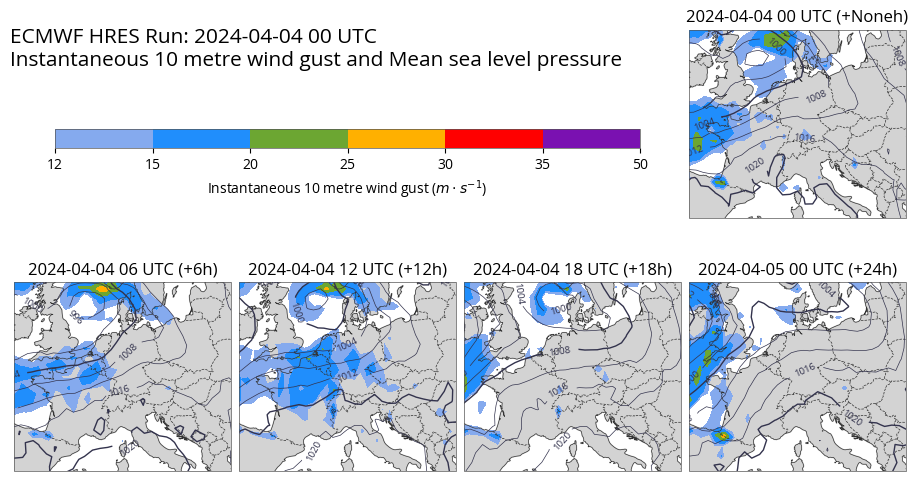

In [8]:
import matplotlib.pyplot as plt

chart = earthkit.maps.Chart(domain=[-5, 23, 40, 58], rows=3, columns=4)

gust_style = earthkit.maps.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

chart.add_subplot(row=0, column=3)
for i in range(4):
    chart.add_subplot(row=1+i//4, column=i%4)

chart.plot(data.sel(shortName="i10fg"), style=gust_style)
chart.plot(data.sel(shortName="msl"), units="hPa")

chart.land(color="lightgrey")
chart.coastlines()
chart.borders()

ax = plt.axes((0.05, 0.8, 0.65, 0.025))
chart.legend(ax=ax)

chart.subplot_titles("{time:%Y-%m-%d %H} UTC (+{lead_time}h)")
chart.title(
    "ECMWF HRES Run: {base_time:%Y-%m-%d %H} UTC\n{variable_name}",
    fontsize=15, horizontalalignment="left", x=0, y=0.96,
)

chart.show()